# Google Earth Radar Images
One possibility for data visualization is to utilize the medium of Google Earth and its fantastic ecosystem of visualization tools. Google Earth can display layers of custom design, as long as they are in the correct format, with the correct vocabularies. It could save some effort on behalf of CHORDS in the visualization domain, as disparate datasets could be displayed in tandem. I'm not sure right not how real-time updates would work, however. The tools are there for either time series data (Point), or radar image overlays (GroundOverlay). 

As is discussed [here](https://stackoverflow.com/a/22693763), the ground overlays need careful handling to conform to the [plate carrée](https://en.wikipedia.org/wiki/Equirectangular_projection) projection that Google Earth prefers. This is probably manageable using Py-ART and Matplotlib, with a little tinkering. It should be noted that I have only seen this requirement in that particular answer, and some cursory Google searches. The link in that SO answer happens to be broken. I will try to do it without changing projections first and see what happens. Perhaps there is some Google magic?

It seems that NWS already uses .kmz as they have a [KMZ Generator page](https://radar.weather.gov/ridge/kmzgenerator.php) for their many radars. [Oceanographers have been using this methodology too](https://ocefpaf.github.io/python4oceanographers/blog/2014/03/10/gearth/), indicating it is not unknown in the geosciences, and may be easy to adopt in CHORDS and elsewhere.

In [142]:
# This file comes from the Convection class of images
EXAMPLE_PATH = '/net/denali/storage2/radar2/people/rgooch/Research/2018-Manuscripts/convnet-radar-features/data/data/convection/20160727'
EXAMPLE_FILE = 'midlothian.tx-20160727-222726.netcdf.gz'
FIGSAVE_PATH = '/net/denali/storage2/radar2/people/rgooch/Research/2018-Manuscripts/transfer-learning-strat-conv'

## Import Utilities and Data
The usual suspects are required of course, in addition to tools that I have developed to interface with Py-ART

In [20]:
import os
import pyart
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gzip
import shutil

# this works if working directory is
# /net/denali/storage2/radar2/people/rgooch/Research/2018-Manuscripts/transfer-learning-strat-conv
from tools.funcs import read_casa_netcdf, impute_missing, scale

from netCDF4 import Dataset
%matplotlib inline

In [33]:
mpl.rcParams["font.size"] = 18

In [16]:
nc_file = os.path.join(EXAMPLE_PATH, EXAMPLE_FILE)

with gzip.open(nc_file, 'rb') as zipped_nc_file:
    with open('temp.nc', 'wb') as nc_file:
        shutil.copyfileobj(zipped_nc_file, nc_file)

In [18]:
# Check that it is lowest elevation
dset = Dataset('temp.nc')
elev_mean = np.mean(dset.variables['Elevation'])
print('The mean elevation in this scan is %.2f'%(elev_mean))

The mean elevation in this scan is 0.79


In [21]:
radar = read_casa_netcdf('temp.nc')

59.94095048025146


In [24]:
fields_to_grid = ['Reflectivity','SpecificPhase','DifferentialReflectivity']

# Impute missing data points to make sure things play nice
# Not Pythonic, I know. But easy for now. In future, need to
# change the impute_missing function to return only the field,
# not the whole radar object
imputed_radar = impute_missing(radar,fields_to_grid[0])
imputed_radar = impute_missing(imputed_radar,fields_to_grid[1])
imputed_radar = impute_missing(imputed_radar,fields_to_grid[2])

## Display Data

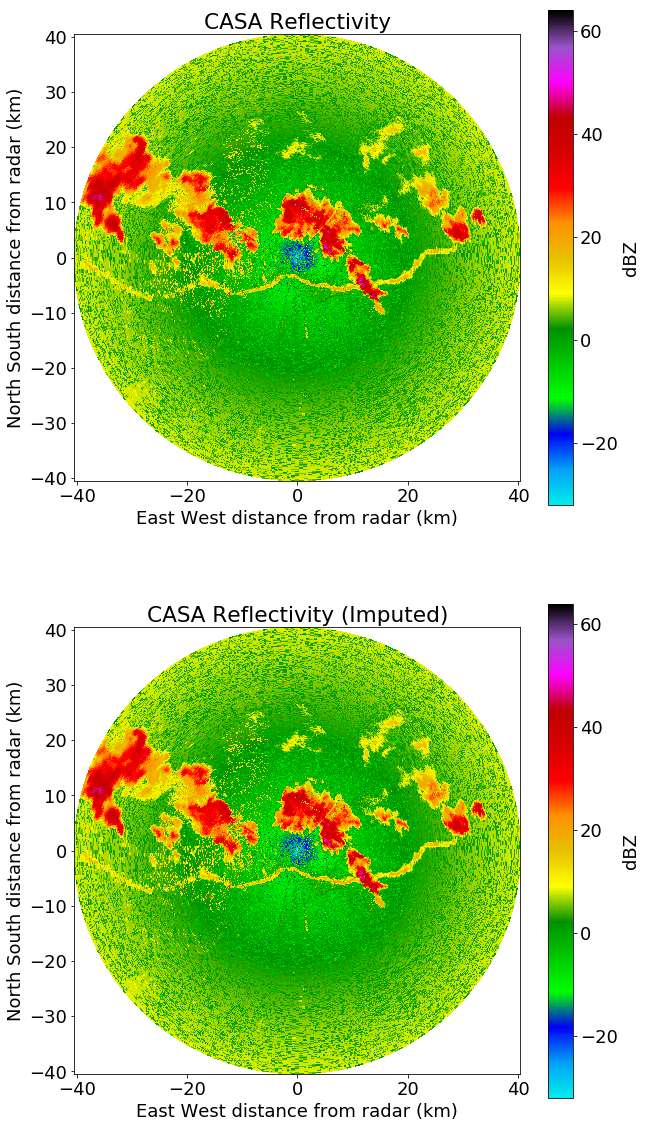

In [38]:
fig = plt.figure(figsize=(10,20))

# ------------------------#
# Raw data
display = pyart.graph.RadarDisplay(radar)

ax = fig.add_subplot(211)
display.plot_ppi(
    'Reflectivity', 
    0, 
    title='CASA Reflectivity',
    vmin=-32,
    vmax=64,
    colorbar_label='dBZ',
    cmap='pyart_NWSRef',
    ax=ax
)
ax.set_aspect('equal')
# ------------------------#

# ------------------------#
# Imputed Data
display = pyart.graph.RadarDisplay(imputed_radar)

ax = fig.add_subplot(212)
display.plot_ppi(
    'Reflectivity', 
    0, 
    title='CASA Reflectivity (Imputed)',
    vmin=-32,
    vmax=64,
    colorbar_label='dBZ',
    cmap='pyart_NWSRef',
    ax=ax
)
ax.set_aspect('equal')
# ------------------------#
plt.show()

In [39]:
# use imputed data as radar henceforth
radar = imputed_radar

In [47]:
for key in radar.fields.keys():
    print(key)

Reflectivity
Velocity
SpectralWidth
DifferentialReflectivity
DifferentialPhase
CrossPolCorrelation
NormalizedCoherentPower
SpecificPhase
CorrectedReflectivity
CorrectedDifferentialReflectivity
SignalToNoiseRatio
RainfallRate
HVReflectivity


In [90]:
x, y, z = radar.get_gate_x_y_z(0)

In [92]:
print(np.max(x))
print(np.max(y))

40423.38293379881
40423.417968335794


In [96]:
ranges = np.array([np.max(x)/1000]*4) # need in km
azimuths = np.array([0., 90., 180., 270.])
elevations = np.array([radar.fixed_angle['data']]*4)

x_cart, y_cart, z_cart = pyart.core.antenna_to_cartesian(ranges, azimuths, elevations)

### Compute some latitude and longitude bounding boxes
[Jan Matuschek Discussion](http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates)

In [99]:
# Angular radius of the query circle, with  Earth Radius
# as 6371 km
r = (np.max(x)/1000.)/6371 
print(r)

0.006344903929335868


In [102]:
np.deg2rad(np.array([40.6892,-74.0444]))

array([ 0.71016051, -1.29231857])

In [114]:
lat = np.deg2rad(radar.latitude['data']) # radians
lon = np.deg2rad(radar.longitude['data']) # radians

# computing latitude is straightforward
lat_min = lat - r
lat_max = lat + r

# longitude is more challenging
lat_T = np.arcsin(np.sin(lat)/np.cos(r))
delta_lon = np.arcsin(np.sin(r)/np.cos(lat))
lon_min = lon - delta_lon
lon_max = lon + delta_lon

lon_min_degrees = np.min([np.rad2deg(lon_min),np.rad2deg(lon_max)])
lon_max_degrees = np.max([np.rad2deg(lon_min),np.rad2deg(lon_max)])

lat_min_degrees = np.min([np.rad2deg(lat_min),np.rad2deg(lat_max)])
lat_max_degrees = np.max([np.rad2deg(lat_min),np.rad2deg(lat_max)])

# Bounding box in degrees
print('The minimum longitude is %.2f'%(lon_min_degrees))
print('The minimum latitude is %.2f'%(lat_min_degrees))
print('The maximum longitude is %.2f'%(lon_max_degrees))
print('The maximum latitude is %.2f'%(lat_max_degrees))

The minimum longitude is -97.43
The minimum latitude is 32.13
The maximum longitude is -96.57
The maximum latitude is 32.86


## Attenuation Correction
Plot both corrected and raw reflectivity data to compare

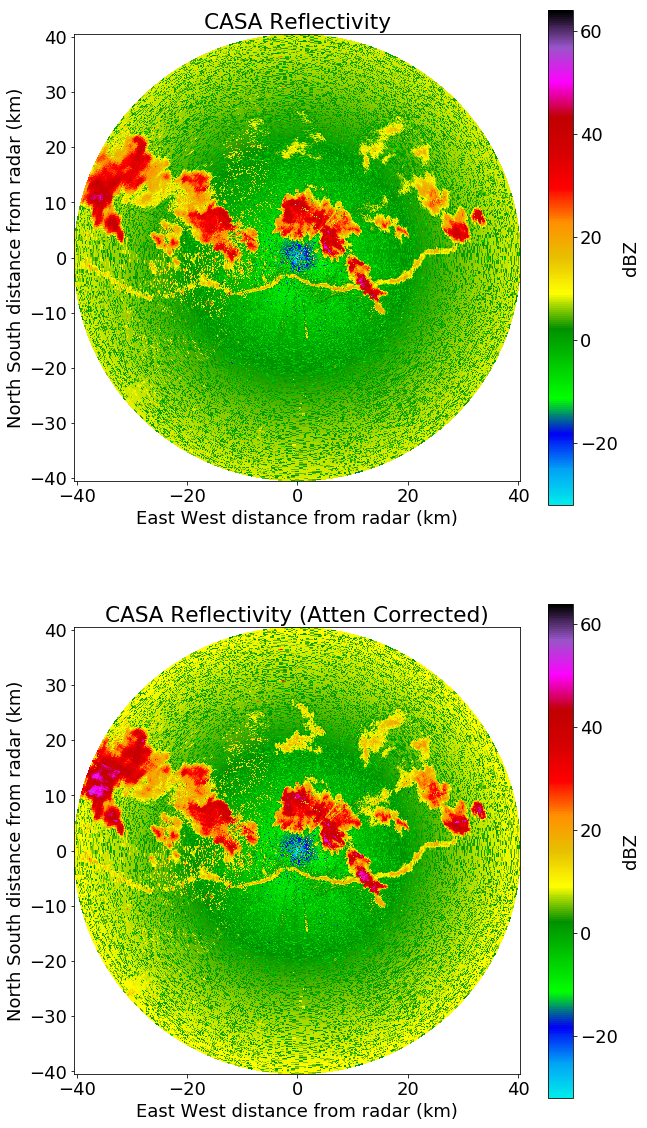

In [49]:
fig = plt.figure(figsize=(10,20))

# ------------------------#
# Raw data
display = pyart.graph.RadarDisplay(radar)

ax = fig.add_subplot(211)
display.plot_ppi(
    'Reflectivity', 
    0, 
    title='CASA Reflectivity',
    vmin=-32,
    vmax=64,
    colorbar_label='dBZ',
    cmap='pyart_NWSRef',
    ax=ax
)
ax.set_aspect('equal')
# ------------------------#

# ------------------------#
# Corrected
display = pyart.graph.RadarDisplay(radar)

ax = fig.add_subplot(212)
display.plot_ppi(
    'CorrectedReflectivity', 
    0, 
    title='CASA Reflectivity (Atten Corrected)',
    vmin=-32,
    vmax=64,
    colorbar_label='dBZ',
    cmap='pyart_NWSRef',
    ax=ax
)
ax.set_aspect('equal')
# ------------------------#
plt.show()

Differences are present but not striking

## Generate Image for Google Earth

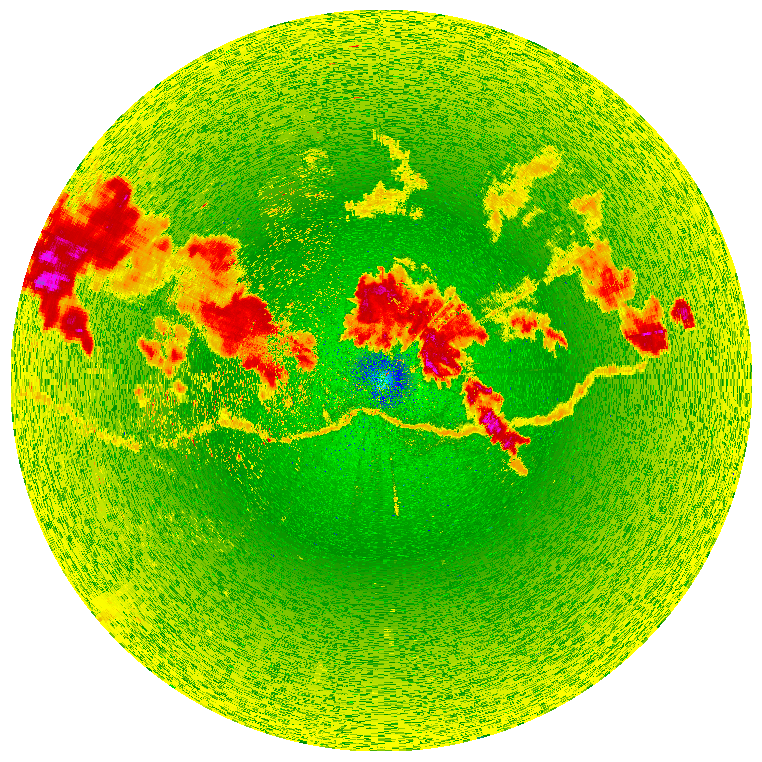

In [174]:
fig = plt.figure(figsize=(30,30))

fig.patch.set_facecolor('black')
fig.patch.set_alpha(0.0)

# Corrected
display = pyart.graph.RadarDisplay(radar)

ax = fig.add_subplot(212)
display.plot_ppi(
    'CorrectedReflectivity', 
    0, 
    title_flag=False,
    vmin=-32,
    vmax=64,
    colorbar_flag=False,
    axislabels_flag=False,
    cmap='pyart_NWSRef',
    ax=ax
)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for border in ['top','right','bottom','left']:
    ax.spines[border].set_visible(False)

plt.savefig(
    os.path.join(FIGSAVE_PATH,'example.png'),
    quality=90,
    facecolor='black',
    transparent=True,
    bbox_inches='tight'
)
plt.show()


## Using SimpleKML
Using [SimpleKML](https://simplekml.readthedocs.io/en/latest/) to generate the ```.kml``` files to use with Google Earth.

In [161]:
from simplekml import Kml

In [162]:
kml = Kml()

In [163]:
ground = kml.newgroundoverlay(name='GroundOverlay')

In [164]:
ground.icon.href = os.path.join(FIGSAVE_PATH,'example.jpg')

In [165]:
# ground.gxlatlonquad.coords = [(lon_min_degrees,lat_min_degrees),(lon_min_degrees,lat_max_degrees),
#                               (lon_max_degrees,lat_max_degrees),(lon_max_degrees,lat_min_degrees)]

ground.latlonbox.north = lat_max_degrees
ground.latlonbox.south = lat_min_degrees
ground.latlonbox.east =  lon_max_degrees
ground.latlonbox.west =  lon_min_degrees

In [166]:
kml.save('GroundOverlay.kml')

/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)
/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)


In [168]:
grid = pyart.map.grid_from_radars(
        (radar,),
        grid_shape = (1, 800, 800),
        grid_limits = ((501,1000), (-41000.0,41000.0), (-41000.0,41000.0)),
        fields=fields_to_grid
    )

## Generate Moving Image for Google Earth

In [180]:
file_list = [
    'midlothian.tx-20160727-222726.netcdf.gz',
    'midlothian.tx-20160727-222825.netcdf.gz',
    'midlothian.tx-20160727-222925.netcdf.gz',
    'midlothian.tx-20160727-223025.netcdf.gz',
    'midlothian.tx-20160727-223125.netcdf.gz',
    'midlothian.tx-20160727-223225.netcdf.gz',
    'midlothian.tx-20160727-223325.netcdf.gz',
    'midlothian.tx-20160727-223425.netcdf.gz',
    'midlothian.tx-20160727-223525.netcdf.gz',
    'midlothian.tx-20160727-223625.netcdf.gz',
]

def gen_radar_image_and_save(nc_file):
    with gzip.open(nc_file, 'rb') as zipped_nc_file:
        with open('temp.nc', 'wb') as nc_file:
            shutil.copyfileobj(zipped_nc_file, nc_file)

    radar = read_casa_netcdf('temp.nc')
    return radar

def plot_image(radar, file_number):
    fig = plt.figure(figsize=(30,30))

    fig.patch.set_facecolor('black')
    fig.patch.set_alpha(0.0)

    # Corrected
    display = pyart.graph.RadarDisplay(radar)

    ax = fig.add_subplot(212)
    display.plot_ppi(
        'CorrectedReflectivity', 
        0, 
        title_flag=False,
        vmin=-32,
        vmax=64,
        colorbar_flag=False,
        axislabels_flag=False,
        cmap='pyart_NWSRef',
        ax=ax
    )
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    for border in ['top','right','bottom','left']:
        ax.spines[border].set_visible(False)

    plt.savefig(
        os.path.join(FIGSAVE_PATH,'example_%d.png'%(file_number)),
        quality=90,
        facecolor='black',
        transparent=True,
        bbox_inches='tight'
    )
    plt.close(fig)

In [176]:
from tqdm import tqdm

In [181]:
counter = 0

for radar_file in tqdm(file_list):
    nc_file = os.path.join(EXAMPLE_PATH, radar_file)
    
    radar_temp = gen_radar_image_and_save(nc_file)
    
    plot_image(radar_temp,counter)
    
    counter = counter + 1

  0%|          | 0/10 [00:00<?, ?it/s]

59.94095048025146


 10%|█         | 1/10 [00:01<00:15,  1.75s/it]

59.94095048025146


 20%|██        | 2/10 [00:03<00:13,  1.73s/it]

59.94095048025146


 30%|███       | 3/10 [00:05<00:12,  1.75s/it]

59.94095048025146


 40%|████      | 4/10 [00:06<00:10,  1.72s/it]

59.94095048025146


 50%|█████     | 5/10 [00:08<00:08,  1.71s/it]

59.94095048025146


 60%|██████    | 6/10 [00:10<00:06,  1.71s/it]

59.94095048025146


 70%|███████   | 7/10 [00:11<00:05,  1.71s/it]

59.94095048025146


 80%|████████  | 8/10 [00:13<00:03,  1.74s/it]

59.94095048025146


 90%|█████████ | 9/10 [00:15<00:01,  1.77s/it]

59.94095048025146


100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


### Moving Image KML

In [182]:
from glob import glob

In [190]:
filelist = sorted(glob('example_*.png'))
kml = Kml()

for png in filelist:
    ground = kml.newgroundoverlay(name='GroundOverlay')
    
    ground.icon.href = os.path.join(FIGSAVE_PATH,png)
    
    ground.timestamp.when = 2016
    
    ground.latlonbox.north = lat_max_degrees
    ground.latlonbox.south = lat_min_degrees
    ground.latlonbox.east =  lon_max_degrees
    ground.latlonbox.west =  lon_min_degrees

In [191]:
kml.save('GroundOverlay_moving.kml')

/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)
/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)
/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)
/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)
/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape instead
  endtext = cgi.escape(text)
/home/rgooch/anaconda3/lib/python3.6/site-packages/simplekml/base.py:94: DeprecationWarning: cgi.escape is deprecated, use html.escape inste